<a href="https://colab.research.google.com/github/YuxingW/deep_learning/blob/main/hw3/part_b1_pytorch_no_auto_differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Pytorch tensor datastructure without auto differentiation

In [17]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

#### 3d-2d non-linear data generation

In [18]:
n_samples = 200
d1 = 3
d2 = 2
x = torch.FloatTensor(n_samples, d1).uniform_(-1,1)

weights_true = torch.FloatTensor([[5, 1, 4],[2, 1, 2]]).T
bias_true = torch.tensor([0.25, 0.1])

y = torch.mm(x ** 2, weights_true) + torch.mm(x, weights_true) + bias_true

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y.shape}')

x: torch.Size([200, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2]), y: torch.Size([200, 2])


#### Define model and loss
Define a nonlinear model using torch

In [19]:
def model(x):
  global weights, bias
  return torch.mm(x ** 2, weights_true) + torch.mm(x, weights) + bias

In [20]:
def backward_update(x, gradient, lr):
  global weights, bias
  weights_gradient = torch.mm(x.T, gradient)
  bias_gradient = gradient.sum()
  x_gradient = torch.mm(gradient, weights.T)
  weights = weights  - lr * weights_gradient
  bias = bias - lr * bias_gradient
  return x_gradient

In [21]:
 class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    #print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

####Initialize weights and bias for model

In [22]:
weights = torch.FloatTensor([[2, 1, 1],[1, 2, 1]]).T
bias = torch.tensor([0.1, 0.1])

In [23]:
import torch.optim as optim

####Initialize learning rate and optimizer

In [24]:
#params = torch.tensor([1.0, 1.0, 1.0, 0.0], requires_grad=False)
learning_rate = 1e-3
optimizer = optim.SGD([weights, bias,], lr=learning_rate)

####Do one step training

In [25]:
y_pred = model(x)
loss = MSE()
loss_value = loss(y_pred, y)
print('loss ', loss_value)
gradient_from_loss = loss.backward()
loss.backward()

backward_update(x, gradient_from_loss, learning_rate)

y_pred.shape

loss  tensor(3.5721)


torch.Size([200, 2])

####Do training loop with 5000 eporches

In [26]:
from typing import Callable

def training_loop(n_epochs, loss: Callable, x, y):
    global weights, bias
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x) 
        loss_value = loss(y_pred, y)
        gradient_from_loss = loss.backward()
        backward_update(x, gradient_from_loss, learning_rate)
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss_value)))
            
    return y_pred

In [27]:
y_pred = training_loop(
    n_epochs = 5000, 
    loss = loss,
    x = x,
    y = y)

Epoch 500, Loss 1.808271
Epoch 1000, Loss 0.918877
Epoch 1500, Loss 0.469355
Epoch 2000, Loss 0.241634
Epoch 2500, Loss 0.126009
Epoch 3000, Loss 0.067166
Epoch 3500, Loss 0.037153
Epoch 4000, Loss 0.021810
Epoch 4500, Loss 0.013950
Epoch 5000, Loss 0.009914


####Plot the output and the real data using tsne

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_comparison(y_true, y_pred):
  #tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=120)
  tsne = TSNE(n_components=2, random_state=0)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(yt_2d[:, 0], yt_2d[:, 1], c='b', label='y_true')
  plt.scatter(yp_2d[:, 1], yp_2d[:, 1], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Comparison')
  plt.xlabel('t_SNE1')
  plt.xlabel('t_SNE2')
  plt.show()

def plot_distribution(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Distribution with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()

In [29]:
y_pred_np = y_pred.detach().numpy()
y_true_np = y.detach().numpy()
x_np = x.detach().numpy()

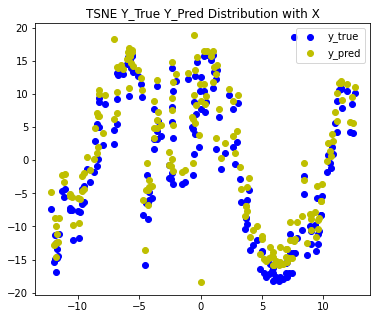

In [30]:
plot_distribution(x_np, y_true_np, y_pred_np)

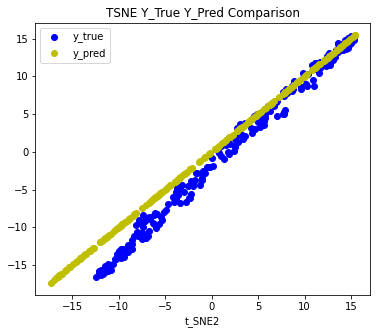

In [31]:
plot_comparison(y_true_np, y_pred_np)

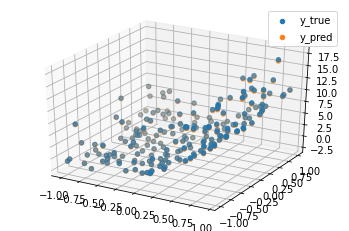

In [34]:
plot_3d(x_np, y_true_np[:, 0], y_pred=y_pred_np[:, 0])

Because there is back propagation, the y_pred is converging to y_true.